In [1]:
import mydatasets
import mymodels
import utils
import DML
import numpy as np
import torch
import copy
import sys
import os
import json 
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchinfo import summary
import pickle

In [2]:
X = pd.read_csv('../data/gene_data.csv', header=None, index_col=0)
X

,1,2,3,4,5,6,7,8,9,10,...,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967
0,,,,,,,,,,,,,,,,,,,,,
SRR1166318,0,0,1,0,0,4,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
ERR176810,0,0,1,0,2,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
ERR181956,0,0,1,0,1,3,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR2100379,0,0,1,0,0,4,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR924706,0,0,1,0,2,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR671746,0,0,1,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR1146372,0,0,2,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ERR176477,0,0,1,0,1,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
Y = pd.read_csv('../data/AllLabels.csv', index_col='id')
Y = Y[Y.index.isin(X.index)]
Y

,amikacin,capreomycin,ciprofloxacin,ethambutol,ethionamide,isoniazid,kanamycin,moxifloxacin,ofloxacin,pyrazinamide,rifampicin,streptomycin
id,,,,,,,,,,,,
SRR3675211,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675215,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675217,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN
SRR3675218,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
SRR3675224,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
SRR924705,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924706,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924707,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [4]:
NoYs = X[np.logical_not(X.index.isin(Y.index))]
print('Xs with no Y found:', NoYs.shape[0])
X = X.drop(NoYs.index)

Xs with no Y found: 115


In [5]:
X = X.sort_index().reset_index().rename(columns={0: 'id'})
Y = Y.sort_index().reset_index()

In [6]:
X_mat = X.iloc[:, 1:].to_numpy()
Y_mat = Y.iloc[:, 1:].to_numpy()

In [7]:
val_test_count = int(X_mat.shape[0] * 0.1)
val_test_indcs = (np.random.permutation(X_mat.shape[0])[:2*val_test_count]).reshape((2, -1))

X_val = X_mat[val_test_indcs[0], :]
Y_val = Y_mat[val_test_indcs[0], :]

X_test = X_mat[val_test_indcs[1], :]
Y_test = Y_mat[val_test_indcs[1], :]

X_train = np.delete(X_mat, val_test_indcs.flatten(), axis=0)
Y_train = np.delete(Y_mat, val_test_indcs.flatten(), axis=0)
print(f'Train Count: {X_train.shape[0]}')
print(f'Validation Count: {X_val.shape[0]}')
print(f'Test Count: {X_test.shape[0]}')

shuffle_indcs = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_indcs, :]
Y_train = Y_train[shuffle_indcs, :]

Train Count: 6277
Validation Count: 784
Test Count: 784


In [8]:
def get_acc_per_drug(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
  emb_train= model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
  emb_val= model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
  KNN = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(emb_train)

  nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
  y_k_neghbors = Y_train[nbr_indcs, :] #y_eval x 5 x 12
  y_pred = np.nanmean(y_k_neghbors, axis=1) #y_eval x 12
  y_pred = np.round(y_pred) #0.5 > --> 1

  acc_per_drug = np.zeros(y_eval.shape[1])
  for i in range(y_eval.shape[1]):
    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval[:, i])), np.logical_not(np.isnan(y_pred[:, i]))))
    acc_per_drug[i] = np.sum(y_pred[condition, i] == y_eval[condition, i]) / y_eval[condition, i].shape[1]
  return acc_per_drug

In [9]:
def get_acc_per_drug_weighted(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    nbr_weights = np.exp(-nbr_dists)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_k_neighbors_weighted = y_k_neghbors * nbr_weights.reshape(-1, n_neighbors, 1)
    #y_pred = np.nanmean(y_k_neighbors_weighted, axis=1) #y_eval x 12
    y_pred = np.nansum(y_k_neighbors_weighted, axis=1) / np.sum(nbr_weights.reshape(-1, n_neighbors, 1), axis=1)
    y_pred = np.round(y_pred) #0.5 > --> 1

    acc_per_drug = np.zeros(y_eval.shape[1])
    for i in range(y_eval.shape[1]):
        condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval[:, i])), np.logical_not(np.isnan(y_pred[:, i]))))
        acc_per_drug[i] = np.sum(y_pred[condition, i] == y_eval[condition, i]) / y_eval[condition, i].shape[1]
    return acc_per_drug

In [10]:
#Change the Folder Name
#ONLY Run if you want to load a model
model = torch.load('../FC_weightedKNN_newtrips_int/model.pth')
with open('../FC_weightedKNN_newtrips_int/lists.list', 'rb') as f:
  loss_list, acc_train_list, acc_eval_list = pickle.load(f)

In [11]:
summary(model, input_size=(500,3967), device='cpu', verbose=0, col_names=['kernel_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
SimpleNet                                --                        --                        --
├─ModuleList: 1-1                        --                        --                        --
│    └─Linear: 2-1                       [3967, 1500]              [500, 1500]               5,952,000
│    └─Linear: 2-2                       [1500, 30]                [500, 30]                 45,030
Total params: 5,997,030
Trainable params: 5,997,030
Non-trainable params: 0
Total mult-adds (G): 3.00
Input size (MB): 7.93
Forward/backward pass size (MB): 6.12
Params size (MB): 23.99
Estimated Total Size (MB): 38.04

In [16]:
untrained = mymodels.SimpleNet(X_train.shape[1], 30, [X_train.shape[1], 1500, 30])
untrained(torch.from_numpy(X_train.astype('float32'))).detach().numpy()[1]


array([0.        , 0.        , 0.27175388, 0.        , 0.02645495,
       0.48039734, 0.08800275, 0.33807653, 0.23176262, 0.        ,
       0.        , 0.04207029, 0.16170645, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02227167, 0.        ,
       0.        , 0.27506796, 0.        , 0.        , 0.03180483,
       0.        , 0.5048445 , 0.3797133 , 0.12155368, 0.        ],
      dtype=float32)

In [17]:
np.sum(untrained(torch.from_numpy(X_train.astype('float32'))).detach().numpy()[1] ==0)

16

In [35]:
model(torch.from_numpy(X_train.astype('float32'))).detach().numpy()[1]

array([0.        , 0.23751208, 0.        , 0.19914417, 0.        ,
       0.23843302, 0.24099775, 0.33574754, 0.        , 0.        ,
       0.14983255, 0.        , 0.        , 0.28986868, 0.28657955,
       0.43012077, 0.33380944, 0.24807048, 0.        , 0.        ,
       0.        , 0.20691521, 0.        , 0.        , 0.        ,
       0.09485403, 0.20713344, 0.        , 0.        , 0.18704143],
      dtype=float32)

In [27]:
get_acc_per_drug(X_train, Y_train, X_test, Y_test, model, 5)

/tmp/ipykernel_17984/193510828.py:8: RuntimeWarning: Mean of empty slice
  y_pred = np.nanmean(y_k_neghbors, axis=1) #y_eval x 12


array([0.7761194 , 0.78921569, 0.92      , 0.90909091, 0.71612903,
       0.94163424, 0.86808511, 0.85333333, 0.8225256 , 0.89303483,
       0.95584416, 0.84735812])

In [32]:
get_acc_per_drug_weighted(X_train, Y_train, X_test, Y_test, model, 5)

array([0.78846154, 0.79620853, 0.93181818, 0.90115321, 0.71604938,
       0.94163424, 0.83950617, 0.88043478, 0.81543624, 0.85990338,
       0.95584416, 0.84435798])

In [10]:
X_test_ = X_test.copy()
Y_test_ =Y_test.copy()
X_train_=X_train.copy()
Y_train_=Y_train.copy()
DML.ROC_Score(model, X_test_, Y_test_,X_train_, Y_train_, limited=False)

[[ 1.  0. -1. ...  1.  1.  1.]
 [-1. -1. -1. ...  0.  0.  0.]
 [-1. -1. -1. ...  0.  0. -1.]
 ...
 [ 1.  1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ...  0.  0.  0.]
 [-1. -1. -1. ...  0.  0. -1.]]


/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/DML.py:135: RuntimeWarning: Mean of empty slice
  y_pred_keras_tmp = np.nanmean(y_k_neghbors, axis=1) #y_eval x 1


0.9221590698419874

/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/DML.py:199: RuntimeWarning: Mean of empty slice
  y_pred_keras_tmp = np.nanmean(y_k_neghbors, axis=1) #y_eval x 1


[[ 1.  0. -1. ...  1.  1.  1.]
 [-1. -1. -1. ...  0.  0.  0.]
 [-1. -1. -1. ...  0.  0. -1.]
 ...
 [ 1.  1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ...  0.  0.  0.]
 [-1. -1. -1. ...  0.  0. -1.]]


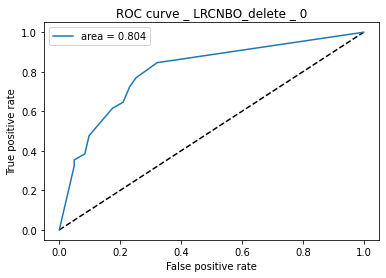

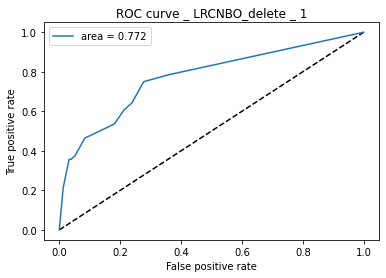

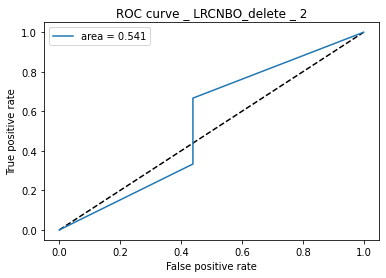

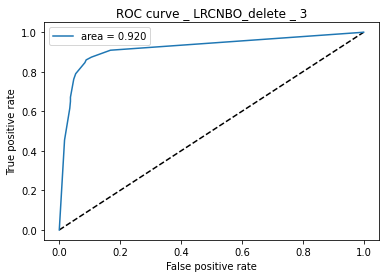

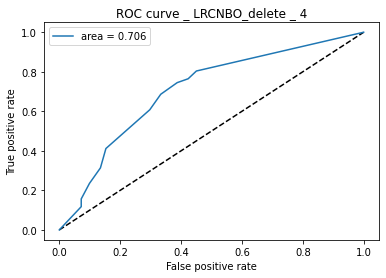

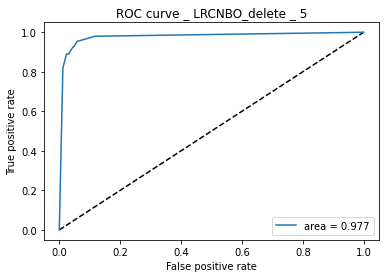

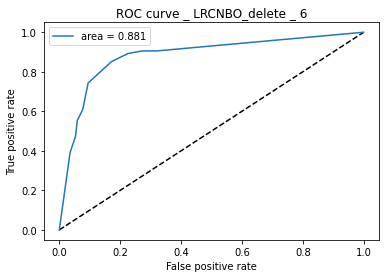

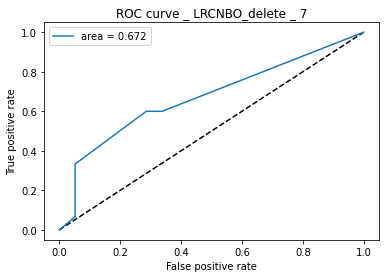

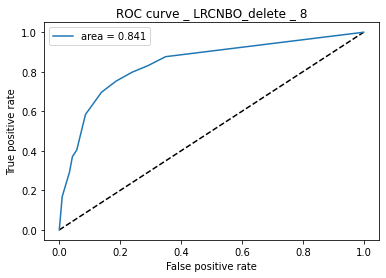

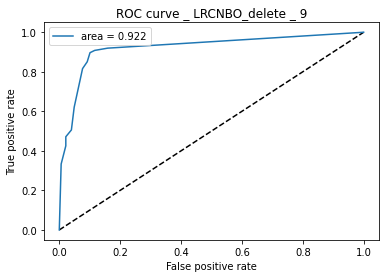

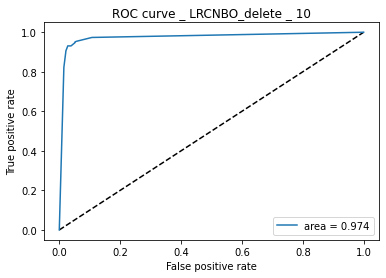

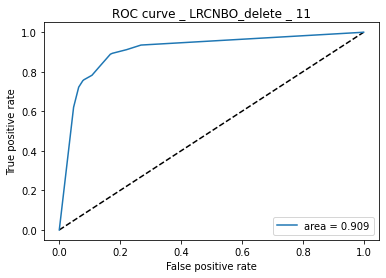

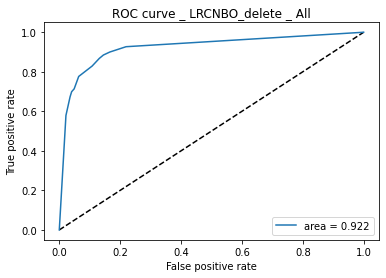

<Figure size 432x288 with 0 Axes>

In [12]:
X_test_ = X_test.copy()
Y_test_ =Y_test.copy()
X_train_=X_train.copy()
Y_train_=Y_train.copy()
score_for_each_drug = DML.ROC(model, X_test_, Y_test_, X_train_, Y_train_, ("LRCN" + "BO_delete"), True)


In [13]:
score_for_each_drug

[0.8035502958579882,
 0.7720622119815667,
 0.540650406504065,
 0.920371654207861,
 0.7055290584702348,
 0.9774770486229174,
 0.8814169198784582,
 0.6718614718614719,
 0.8408418902209559,
 0.9215438152483392,
 0.9743971651231084,
 0.9090852597564006]

In [14]:
X_test_ = X_test.copy()
Y_test_ =Y_test.copy()
X_train_=X_train.copy()
Y_train_=Y_train.copy()
spec_recall, prec_recall = DML.PR(model, X_test_, Y_test_, X_train_, Y_train_)

/media/indirected/Local Disk/University/Work/Metrtic Learning/multilabel-deep-metric/src/DML.py:342: RuntimeWarning: Mean of empty slice
  y_pred_keras_tmp = np.nanmean(y_k_neghbors, axis=1) #y_eval x 1


In [15]:
spec_recall

[0.3384615384615385,
 0.375,
 0,
 0.7902097902097902,
 0,
 0.9393063583815029,
 0.47297297297297297,
 0.19999999999999998,
 0.4044943820224719,
 0.6206896551724138,
 0.9490131578947368,
 0.6203703703703703]

In [16]:
prec_recall

[0.669634224079618,
 0.6346661020654103,
 0.22890749601275917,
 0.8436363374669098,
 0.505028402992723,
 0.9781309576307673,
 0.7909319692960555,
 0.3453395370926927,
 0.7215221180486179,
 0.8132328404245237,
 0.9714391724556787,
 0.8936370721424921]

In [ ]:
maxlen = 0
maxi = 0
Y_train_maskable = np.ma.array(Y_mat, mask=False)
for i in tqdm(range(Y_mat.shape[0])):
    Y_train_maskable.mask[i] = True
    sim_uniq, sim_counts = np.unique(np.sum(Y_train_maskable == Y_mat[i], axis=1), return_counts=True)
    sim_uniq = sim_uniq.compressed()
    if maxlen < sim_uniq.shape[0] and np.all(sim_counts[:-1] > 10):
        maxlen = sim_uniq.shape[0]
        maxi = i
    Y_train_maskable.mask[i] = False

print(f'Max Similarity Count: {maxlen}')
print(f'Best Anchor Index: {maxi}')

  0%|          | 0/7845 [00:00<?, ?it/s]

Max Similarity Count: 12
Best Anchor Index: 1514


In [ ]:
sim_list_indcs = []
for i in range(maxlen):
    sim_list_indcs.append(np.where(np.sum(Y_mat == Y_mat[maxi], axis=1) == i)[0])

In [ ]:
emb_train = model(torch.from_numpy(X_mat.astype('float32'))).detach().numpy()
tsne_train = TSNE(n_components=2, metric='euclidean').fit_transform(emb_train)

/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


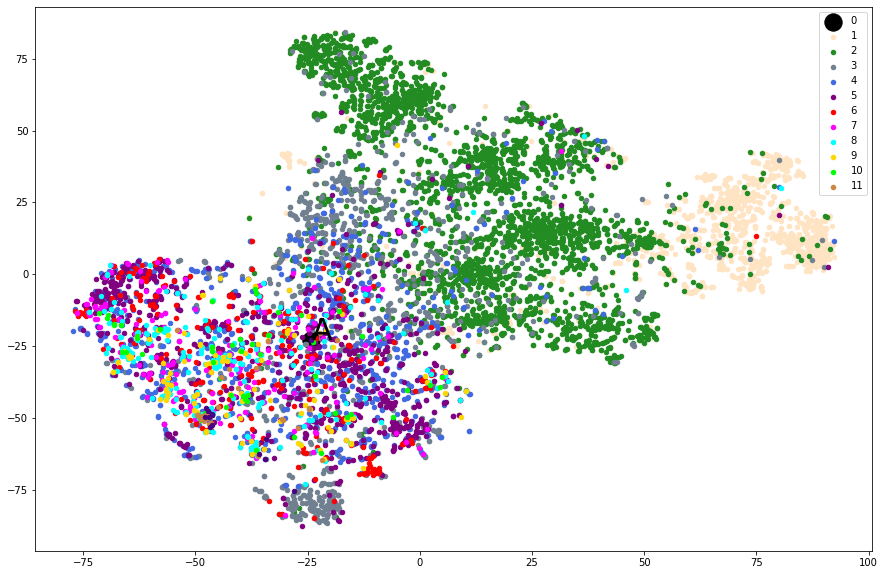

In [ ]:
fig, ax = plt.subplots()

ax.scatter(tsne_train[maxi, 0], tsne_train[maxi, 1], s=300, c='black')
ax.annotate('A', (tsne_train[maxi, 0], tsne_train[maxi, 1]), fontsize= 30)
colors = ['bisque', 'forestgreen', 'slategrey', 'royalblue', 'purple', 'red', 'magenta', 'cyan', 'gold', 'lime', 'peru', 'indigo']
for i in range(maxlen):        
    ax.scatter(tsne_train[sim_list_indcs[i][:], 0], tsne_train[sim_list_indcs[i][:], 1], s=20, c=colors[i])
    #ax.annotate(str(i), (tsne_train[sim_list_indcs[i][0], 0], tsne_train[sim_list_indcs[i][0], 1]), fontsize=20)
ax.legend([str(i) for i in range(maxlen)])
fig.set_size_inches((15,10))